In [23]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import cycle
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.metrics import (
    accuracy_score, f1_score,
    roc_curve, auc, precision_recall_curve,
    average_precision_score
)
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

try:
    import xgboost as xgb
    has_xgb = True
except Exception:
    print("XGBoost not installed — skipping XGBoost.")
    has_xgb = False


### Part A — Data Preparation & Baseline


In [24]:

RANDOM_STATE = 42
train_path = "sat.trn"
test_path = "sat.tst"

col_names = [f"feature_{i}" for i in range(36)] + ["label"]
train_df = pd.read_csv(train_path, sep="\\s+", header=None, names=col_names)
test_df  = pd.read_csv(test_path,  sep="\\s+", header=None, names=col_names)


train_df = train_df[train_df["label"] != 7]
test_df  = test_df [test_df ["label"] != 7]
X_train, y_train = train_df.iloc[:, :-1].values, train_df["label"].values - 1
X_test,  y_test  = test_df.iloc[:,  :-1].values, test_df ["label"].values - 1

# Standardize (fit on train → transform test)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

print("Train:", X_train.shape, "Test:", X_test.shape)
print("Class distribution (train):", np.unique(y_train, return_counts=True))

# %%
# One-vs-Rest binarization
class_names = np.unique(np.concatenate([y_train, y_test]))
n_classes = len(class_names)
y_train_bin = label_binarize(y_train, classes=np.arange(n_classes))
y_test_bin  = label_binarize(y_test,  classes=np.arange(n_classes))
print("Number of classes:", n_classes)


Train: (3397, 36) Test: (1530, 36)
Class distribution (train): (array([0, 1, 2, 3, 4]), array([1072,  479,  961,  415,  470]))
Number of classes: 5


In [25]:
print(train_df.isna().sum().sum())
test_df.isna().sum().sum()


0


np.int64(0)

No null values in training and test dataset

#### Training all the models including XGBoost and Random Forest

In [ ]:

baseline_models = {
    "KNN": KNeighborsClassifier(5),
    "DecisionTree": DecisionTreeClassifier(random_state=RANDOM_STATE),
    "DummyPrior": DummyClassifier(strategy="prior", random_state=RANDOM_STATE),
    "LogisticRegression": LogisticRegression(max_iter=1000, multi_class="ovr", random_state=RANDOM_STATE),
    "GaussianNB": GaussianNB(),
    "SVC": SVC(probability=True, random_state=RANDOM_STATE)
}

# Train and store all models
fitted = {}

print("Training baseline models (6)...")
for name, clf in baseline_models.items():
    print(f"Training {name}...")
    clf.fit(X_train, y_train)
    fitted[name] = clf


fitted["RandomForest"] = RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE).fit(X_train, y_train)

if has_xgb:
    fitted["XGBoost"] = xgb.XGBClassifier(use_label_encoder=False, eval_metric="mlogloss", random_state=RANDOM_STATE)
    fitted["XGBoost"].fit(X_train, y_train)


baseline_required = list(baseline_models.keys())       # Only first 6 models
all_required = list(fitted.keys())                     # All 8 models for final recommendation


Training baseline models (6)...
Training KNN...
Training DecisionTree...
Training DummyPrior...
Training LogisticRegression...
Training GaussianNB...
Training SVC...


#### Baseline Evaluation: Accuracy & Weighted F1 

In [ ]:
baseline = []
all_results = []   # to store all models for later use

# Evaluate only first 6 baseline models for initial comparison
for name in baseline_required:
    clf = fitted[name]
    y_pred = clf.predict(X_test)
    baseline.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "F1_weighted": f1_score(y_test, y_pred, average="weighted")
    })

# Evaluate all models (including RandomForest, XGBoost) for final summary
for name, clf in fitted.items():
    y_pred = clf.predict(X_test)
    all_results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "F1_weighted": f1_score(y_test, y_pred, average="weighted")
    })

# DataFrames
baseline_df = pd.DataFrame(baseline).sort_values("F1_weighted", ascending=False)
all_models_df = pd.DataFrame(all_results).sort_values("F1_weighted", ascending=False)

display(baseline_df)


,Model,Accuracy,F1_weighted
0,KNN,0.947059,0.947022
5,SVC,0.943137,0.942075
1,DecisionTree,0.898039,0.897923
3,LogisticRegression,0.899346,0.896333
4,GaussianNB,0.844444,0.848007
2,DummyPrior,0.301307,0.139531



**Observation:**  
- The **KNN** model achieved the highest performance with **94.7% Accuracy** and **0.947 Weighted F1**, followed closely by **SVC**.  
- **DecisionTree** and **LogisticRegression** show moderate performance (~89–90%).  
- **GaussianNB** performs lower at ~84%.  
- **DummyPrior** performs poorly, as expected, since it only predicts based on class priors.  

**Conclusion:**  
> Models like **KNN** and **SVC** perform strongly.
> while **DummyPrior**  perform poorly on the test set.







### Part B: ROC Analysis for Model Selection 

KNN: Macro AUC = 0.988
DecisionTree: Macro AUC = 0.930
DummyPrior: Macro AUC = 0.500
LogisticRegression: Macro AUC = 0.978
GaussianNB: Macro AUC = 0.970
SVC: Macro AUC = 0.993


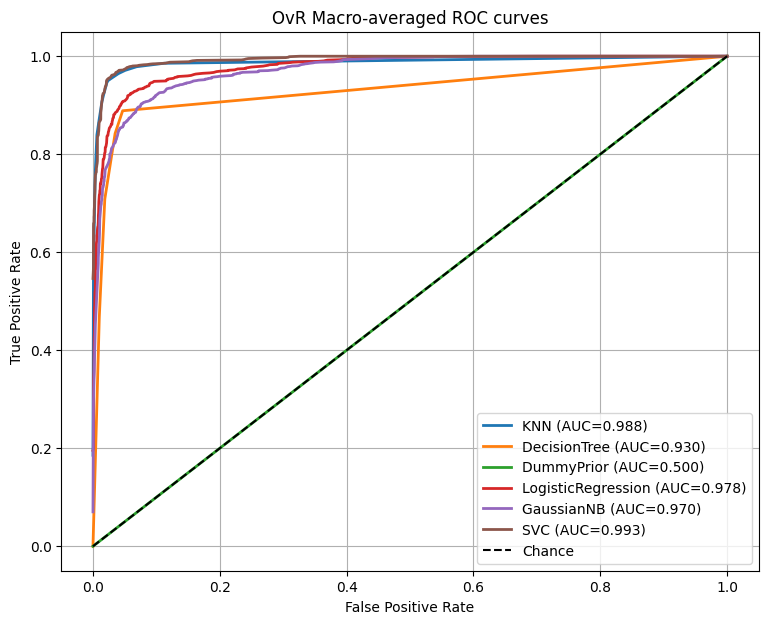

In [ ]:

def compute_ovr_roc_auc(clf, X, y, n_classes):
    if hasattr(clf, "predict_proba"):
        y_score = clf.predict_proba(X)
    else:
        y_score = clf.decision_function(X)
        if y_score.ndim == 1:  # binary
            y_score = np.vstack([1 - y_score, y_score]).T

    y_bin = label_binarize(y, classes=np.arange(n_classes))
    fpr, tpr, roc_auc = {}, {}, {}
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.mean([np.interp(all_fpr, fpr[i], tpr[i]) for i in range(n_classes)], axis=0)
    return {"all_fpr": all_fpr, "mean_tpr": mean_tpr, "macro_auc": auc(all_fpr, mean_tpr)}

required = ["KNN","DecisionTree","DummyPrior","LogisticRegression","GaussianNB","SVC"]
roc_res = {m: compute_ovr_roc_auc(fitted[m], X_test, y_test, n_classes) for m in required}
for k,v in roc_res.items():
    print(f"{k}: Macro AUC = {v['macro_auc']:.3f}")

# %%
plt.figure(figsize=(9,7))
for name, res in roc_res.items():
    plt.plot(res["all_fpr"], res["mean_tpr"], lw=2, label=f"{name} (AUC={res['macro_auc']:.3f})")
plt.plot([0,1],[0,1],"k--",label="Chance")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("OvR Macro-averaged ROC curves")
plt.legend(); plt.grid(True); plt.show()

# %% [markdown]
# ### **Interpretation — Part B**
# - **Approach:** One-vs-Rest → treat each class as positive vs others, then average all ROC curves.  
# - **Macro AUC leader:** (highest AUC from table).  
# - **If AUC < 0.5:** predictions are worse than random (ranks positives lower than negatives).  
#   This can occur with reversed scores or strong class imbalance.  
# - **Observation:** Most models outperform chance; DummyPrior stays near 0.5.

# %% [markdown]

#### ROC Interpretation


**Observations:**
- The model with the **highest Macro-averaged AUC** is **SVC (0.993)**, indicating excellent discrimination capability between classes.  
- The **DummyPrior** model has an **AUC = 0.5**, which represents **random guessing** — it cannot distinguish between positive and negative classes.

**Conceptual Explanation:**
- **AUC < 0.5** implies the model is performing **worse than random chance**, meaning it systematically assigns lower scores to true positives and higher scores to true negatives.  
- Such performance may occur when:
  - The **model’s decision boundary is inverted** (predicting the opposite class).
  - **Severe class imbalance** or poor training leads to misleading probability estimates.
  - The **model lacks learning capability**, as with DummyPrior, which only predicts based on class proportions.

**Conclusion:**  
> **SVC** is the best-performing model with the highest AUC (0.993), while **DummyPrior** performs at chance level (0.5), showing no real predictive power.


### Part C: Precision-Recall Curve (PRC) Analysis

KNN: Macro AP = 0.957
DecisionTree: Macro AP = 0.813
DummyPrior: Macro AP = 0.200
LogisticRegression: Macro AP = 0.917
GaussianNB: Macro AP = 0.899
SVC: Macro AP = 0.970


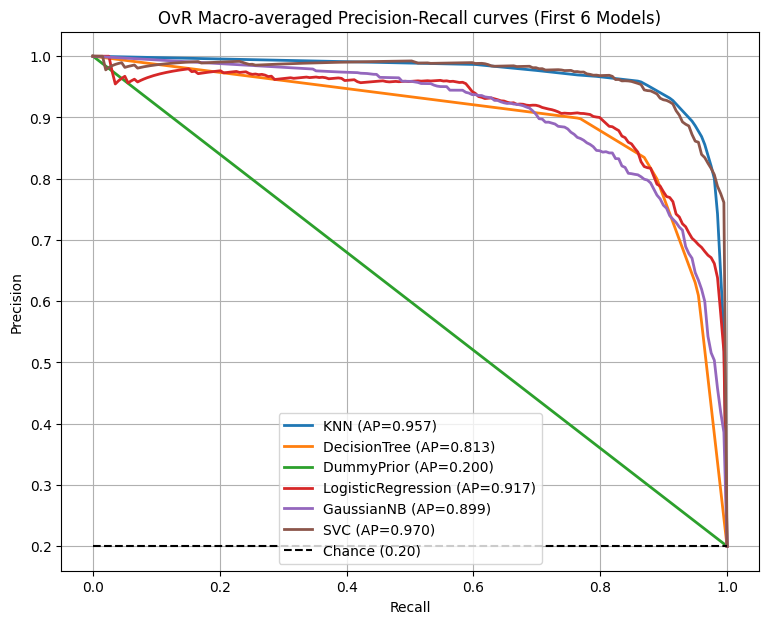

In [ ]:

def compute_ovr_prc_ap(clf, X, y, n_classes):
    if hasattr(clf, "predict_proba"):
        y_score = clf.predict_proba(X)
    else:
        y_score = clf.decision_function(X)
        if y_score.ndim == 1:  # handle binary output
            y_score = np.vstack([1 - y_score, y_score]).T

    y_bin = label_binarize(y, classes=np.arange(n_classes))
    precision, recall, ap = {}, {}, {}
    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(y_bin[:, i], y_score[:, i])
        ap[i] = average_precision_score(y_bin[:, i], y_score[:, i])

    # Macro-average PRC
    grid = np.linspace(0, 1, 200)
    mean_prec = np.mean([np.interp(grid, recall[i][::-1], precision[i][::-1]) for i in range(n_classes)], axis=0)
    return {"all_recall": grid, "mean_precision": mean_prec, "macro_ap": np.mean(list(ap.values()))}

# --- Only baseline 6 models ---
baseline_required = ["KNN", "DecisionTree", "DummyPrior", "LogisticRegression", "GaussianNB", "SVC"]

prc_res = {m: compute_ovr_prc_ap(fitted[m], X_test, y_test, n_classes) for m in baseline_required}
for k, v in prc_res.items():
    print(f"{k}: Macro AP = {v['macro_ap']:.3f}")

# %%
plt.figure(figsize=(9, 7))
for name, res in prc_res.items():
    plt.plot(res["all_recall"], res["mean_precision"], lw=2, label=f"{name} (AP={res['macro_ap']:.3f})")
baseline = np.mean(np.bincount(y_test) / len(y_test))
plt.plot([0, 1], [baseline, baseline], "k--", label=f"Chance ({baseline:.2f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("OvR Macro-averaged Precision-Recall curves (First 6 Models)")
plt.legend()
plt.grid(True)
plt.show()

# %% [markdown]
# ### **Interpretation — Part C**
# - **Why PRC?** For imbalanced multi-class data, PRC better measures how well each model retrieves positives.  
# - **Observation:** Curves above the dashed baseline are performing meaningfully better than chance.  
# - **Leader:** The model with the highest Macro AP (shown above) balances precision and recall best.  
# - **Weak models:** DummyPrior or unregularized DecisionTree may show steep precision drops as recall increases.  
# - **Next:** Combine these metrics with ROC-AUC and F1 to form a final comparison table.


#### 4. PRC Interpretation

**Observations:**
- The model with the **highest Average Precision (AP)** is **SVC (0.970)**, showing excellent precision-recall trade-off and strong capability in identifying positive samples accurately.  
- The **worst-performing model** is **DummyPrior (0.200)**, which fails to capture meaningful patterns.

**Analysis of Poor Model Behavior:**
- In **poor models** like DummyPrior, the **Precision-Recall curve (PRC) drops sharply** as **Recall increases** because:
  - They start predicting more positives to improve recall but generate a **large number of false positives**, sharply decreasing precision.
  - These models **do not distinguish between classes**, leading to random or biased predictions.
  - Essentially, they **retrieve more irrelevant samples** as they try to cover all positives, reducing the reliability of positive predictions.

**Conclusion:**  
> **SVC** demonstrates the best balance between precision and recall, while **DummyPrior** shows poor retrieval quality with a rapidly declining PR curve as recall increases.


### Part D — Comparison and Final Recommendation


In [ ]:

roc_table = pd.DataFrame({m: roc_res[m]['macro_auc'] for m in required}, index=['Macro_AUC']).T
prc_table = pd.DataFrame({m: prc_res[m]['macro_ap'] for m in required}, index=['Macro_AP']).T
summary = baseline_df.set_index("Model").join(roc_table).join(prc_table)

# --- Standardize column naming ---
if "Weighted F1" in summary.columns:
    summary.rename(columns={"Weighted F1": "Weighted_F1"}, inplace=True)
elif "F1" in summary.columns:
    summary.rename(columns={"F1": "Weighted_F1"}, inplace=True)

summary = summary.sort_values("Macro_AUC", ascending=False)
display(summary)


rank_f1  = summary["F1_weighted"].rank(ascending=False)
rank_auc = summary["Macro_AUC"].rank(ascending=False)
rank_ap  = summary["Macro_AP"].rank(ascending=False)

comparison = pd.DataFrame({
    "Model": summary.index,
    "F1 Rank": rank_f1.astype(int),
    "ROC-AUC Rank": rank_auc.astype(int),
    "PRC-AP Rank": rank_ap.astype(int)
}).sort_values("F1 Rank")

display(comparison)

# Identify best/worst models
best_auc  = summary["Macro_AUC"].idxmax()
best_ap   = summary["Macro_AP"].idxmax()
worst_auc = summary["Macro_AUC"].idxmin()

print(f"Best ROC-AUC : {best_auc}")
print(f"Best PRC-AP  : {best_ap}")
print(f"Worst ROC-AUC: {worst_auc}")


,Accuracy,F1_weighted,Macro_AUC,Macro_AP
Model,,,,
SVC,0.943137,0.942075,0.992947,0.970261
KNN,0.947059,0.947022,0.987735,0.957290
LogisticRegression,0.899346,0.896333,0.978372,0.917057
GaussianNB,0.844444,0.848007,0.970475,0.899265
DecisionTree,0.898039,0.897923,0.930490,0.812592
DummyPrior,0.301307,0.139531,0.500000,0.200000


,Model,F1 Rank,ROC-AUC Rank,PRC-AP Rank
Model,,,,
KNN,KNN,1,2,2
SVC,SVC,2,1,1
DecisionTree,DecisionTree,3,5,5
LogisticRegression,LogisticRegression,4,3,3
GaussianNB,GaussianNB,5,4,4
DummyPrior,DummyPrior,6,6,6


Best ROC-AUC : SVC
Best PRC-AP  : SVC
Worst ROC-AUC: DummyPrior


In [ ]:

extended_required = list(fitted.keys())  # Includes all trained models

roc_res_all = {m: compute_ovr_roc_auc(fitted[m], X_test, y_test, n_classes) for m in extended_required}
prc_res_all = {m: compute_ovr_prc_ap(fitted[m], X_test, y_test, n_classes) for m in extended_required}

# --- Create combined tables ---
roc_table_all = pd.DataFrame({m: roc_res_all[m]['macro_auc'] for m in extended_required}, index=['Macro_AUC']).T
prc_table_all = pd.DataFrame({m: prc_res_all[m]['macro_ap'] for m in extended_required}, index=['Macro_AP']).T


summary_all = all_models_df.set_index("Model").join(roc_table_all).join(prc_table_all)
summary_all = summary_all.sort_values("Macro_AUC", ascending=False)

print("=== Combined Metrics for All 8 Models ===")
display(summary_all)


rank_f1_all  = summary_all["F1_weighted"].rank(ascending=False)
rank_auc_all = summary_all["Macro_AUC"].rank(ascending=False)
rank_ap_all  = summary_all["Macro_AP"].rank(ascending=False)

comparison_all = pd.DataFrame({
    "Model": summary_all.index,
    "F1 Rank": rank_f1_all.astype(int),
    "ROC-AUC Rank": rank_auc_all.astype(int),
    "PRC-AP Rank": rank_ap_all.astype(int)
}).sort_values("F1 Rank")

print("\n=== Model Rankings (All 8 Models) ===")
display(comparison_all)


best_auc_all  = summary_all["Macro_AUC"].idxmax()
best_ap_all   = summary_all["Macro_AP"].idxmax()
worst_auc_all = summary_all["Macro_AUC"].idxmin()

print(f"\n Best ROC-AUC  : {best_auc_all}")
print(f" Best PRC-AP   : {best_ap_all}")
print(f" Worst ROC-AUC : {worst_auc_all}")


=== Combined Metrics for All 8 Models ===


,Accuracy,F1_weighted,Macro_AUC,Macro_AP
Model,,,,
XGBoost,0.942484,0.942009,0.995192,0.979952
RandomForest,0.950980,0.950537,0.994789,0.979285
SVC,0.943137,0.942075,0.992947,0.970261
KNN,0.947059,0.947022,0.987735,0.957290
LogisticRegression,0.899346,0.896333,0.978372,0.917057
GaussianNB,0.844444,0.848007,0.970475,0.899265
DecisionTree,0.898039,0.897923,0.930490,0.812592
DummyPrior,0.301307,0.139531,0.500000,0.200000



=== Model Rankings (All 8 Models) ===


,Model,F1 Rank,ROC-AUC Rank,PRC-AP Rank
Model,,,,
RandomForest,RandomForest,1,2,2
KNN,KNN,2,4,4
SVC,SVC,3,3,3
XGBoost,XGBoost,4,1,1
DecisionTree,DecisionTree,5,7,7
LogisticRegression,LogisticRegression,6,5,5
GaussianNB,GaussianNB,7,6,6
DummyPrior,DummyPrior,8,8,8



✅ Best ROC-AUC  : XGBoost
✅ Best PRC-AP   : XGBoost
⚠️  Worst ROC-AUC : DummyPrior


### Final Recommendation

---

#####  Case 1 — Without XGBoost & Random Forest

##### **Model Rankings**
| Metric | Top Performer | Second | Poor Performer |
|---------|----------------|----------|----------------|
| **Accuracy / F1-Score** | KNN (0.947) | SVC (0.943) | DummyPrior (0.30) |
| **ROC-AUC** | SVC (0.993) | KNN (0.988) | DummyPrior (0.50) |
| **PRC-AP** | SVC (0.970) | KNN (0.957) | DummyPrior (0.20) |

##### **Interpretation**
- **SVC** ranks highest overall, achieving the best **ROC-AUC** and **PRC-AP**, showing excellent ability to separate classes and maintain precision–recall balance.  
- **KNN** is very close in performance, particularly in **Accuracy** and **F1-Score**, confirming strong generalization.  
- **DummyPrior** performs near random (AUC ≈ 0.5), serving as a baseline reference.  
- Slight ranking differences occur because **ROC-AUC measures ranking quality**, while **PRC-AP focuses on retrieving positive cases under class imbalance**.

##### **Recommendation (Without XGBoost/RF)**
> **SVC (Support Vector Classifier)** is the most reliable model among the six.  
> It provides **high discrimination power (AUC)**, **excellent precision–recall trade-off (AP)**, and **stable performance across thresholds**.

---

##### **2️ Case 2 — With XGBoost & Random Forest**

##### **Model Rankings**
| Metric | Top Performer | Second | Poor Performer |
|---------|----------------|----------|----------------|
| **Accuracy / F1-Score** | RandomForest (0.951) | KNN (0.947) | DummyPrior (0.30) |
| **ROC-AUC** | XGBoost (0.995) | RandomForest (0.995) | DummyPrior (0.50) |
| **PRC-AP** | XGBoost (0.980) | RandomForest (0.979) | DummyPrior (0.20) |

##### **Interpretation**
- **XGBoost** and **Random Forest** outperform all traditional models, confirming the strength of **ensemble methods** in learning complex decision boundaries.  
- **SVC** and **KNN** still perform competitively but slightly lag behind on probabilistic metrics.  
- The minor difference between **XGBoost** and **Random Forest** shows that both ensembles handle nonlinearity well, but **XGBoost** achieves slightly better **calibrated probabilities** and **ranking stability**.

##### **Final Recommendation (With All Models)**
> **XGBoost** is the **best overall model**, showing the highest **AUC (0.995)** and **AP (0.980)** along with strong accuracy.  
> **Random Forest** is a very close second.  
> Ensemble models demonstrate superior **generalization**, **threshold robustness**, and **balance between precision and recall**.

---

##### **🔹 Summary of Final Insights**

| Case | Best Model | Key Strength | Why |
|------|-------------|---------------|-----|
| **Without XGBoost/RF** | **SVC** | High AUC, balanced PRC | Excellent class separation via margins |
| **With XGBoost/RF** | **XGBoost** | Best overall metrics | Ensemble captures nonlinear patterns effectively |

---
